# Global Waste Analysis #
*by Rosana de Oliveira Gomes*

Analysis of waste in global and country scale considering the following datasets:

* TrashOut dataset for location and type of illegal trash, 
* [What a waste dataset (World Bank)](https://datacatalog.worldbank.org/dataset/what-waste-global-database) for country based reported waste indicators,  
* [World Bank Indicators (WBI)](https://data.worldbank.org/indicator) for socio-economic factors relevant for waste disposal.

Both World Bank data sets used contain data for the year of 2018. 

In [1]:
# jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True WBI-TrashOut-Analysis.ipynb 

%matplotlib inline
import numpy as np
import pandas as pd
import os
from pprint import pprint 
import matplotlib.pyplot as plt
import subprocess


pd.options.display.max_rows = 20

In [2]:
# Loading WBI dataset

df_wb_data = pd.read_csv("wbi-data-trashout.csv")
#df_wb_data.head(220)

df_wb_data.replace('..', np.nan, inplace=True)

#df_wb_data

## Selecting socio-economic indicators from WBI ##

We start the analysis selecting 54 World Bank Indicators which can be relevant for the illegal dumping investigation. The indicators pre selected are the following:

In [3]:
# Set is a function that makes elements appear only once

pprint(set(df_wb_data['Series Name']))

{'Access to electricity (% of population)',
 'Adjusted net enrollment rate, primary (% of primary school age children)',
 'Adjusted savings: education expenditure (% of GNI)',
 'Adjusted savings: net forest depletion (% of GNI)',
 'CO2 emissions (metric tons per capita)',
 'CPIA business regulatory environment rating (1=low to 6=high)',
 'CPIA policy and institutions for environmental sustainability rating (1=low '
 'to 6=high)',
 'CPIA transparency, accountability, and corruption in the public sector '
 'rating (1=low to 6=high)',
 'Electricity production from renewable sources, excluding hydroelectric (% of '
 'total)',
 'Forest area (% of land area)',
 'GDP (current US$)',
 'GDP growth (annual %)',
 'GNI growth (annual %)',
 'GNI per capita growth (annual %)',
 'Immunization, DPT (% of children ages 12-23 months)',
 'Immunization, HepB3 (% of one-year-old children)',
 'Immunization, measles (% of children ages 12-23 months)',
 'Income share held by highest 20%',
 'Income share held 

In [4]:
# Selecting countries and codes

countries = set(zip(df_wb_data['Country Name'], df_wb_data['Country Code']))

#pprint(len(countries))

## Preliminary profile of WBI dataset ##

Using pandas profiling, we identify which indicators have significant amounts of missing values, and also check the statistics on the data for all countries in the data set. This is used to define which indicators are going to be merged to the TrashOut data set for further analysis. 

In [5]:
#######################
# Pandas profiling  #
######################

# Reshape data frame for columns: series name, rows: countries

#filtered_countries = df_wb_data[((df_wb_data['Country Name'] == 'China') 
#                      | (df_wb_data['Country Name'] == 'Philippines') 
#                      | (df_wb_data['Country Name'] == 'Japan')]

# All countries
countries= sorted(countries)
    
# List of all series
series = sorted(set(df_wb_data['Series Name']))

# Subset of series
# filtered_series= filtered_countries[(filtered_countries['Series Name'] == 'Population, female (% of total population)')]


# Create new data frame that contains countries as row 
country, code = zip(*countries)
data = {'Country': country, 'Country Code': code}

df_wb_profiling=  pd.DataFrame(data)

year='2018 [YR2018]'

# Filter series from filtered countries
# Add column of series for a fixed year to the new data frame 

for series_name in series:
    
    filtered_series= df_wb_data[(df_wb_data['Series Name'] == series_name)]
    df_wb_profiling[series_name] = list(filtered_series[year])
    
    #pprint(filtered_series[year])
    
#df_wb_profiling.head(20)


In [6]:
# Look at the first row (the first country)

#df_wb_profiling.iloc[0]

In [7]:
import pandas_profiling

# Descriptive statistics

#df_wb_profiling.describe()

In [8]:
# Profiling Report

#profile = pandas_profiling.ProfileReport(df_wb_profiling, minimal=True)
#profile.to_file(output_file="profile-wb-trashout.html")

## Selected indicators for analysis (percentage of missing values) ##

1. Access to electricity (% of population)                                                     (0.9%)
2. Adjusted savings: education expenditure (% of GNI)                             (8.8%)
3. Adjusted savings: net forest depletion (% of GNI)                                  (21.7%)
4. GDP (current US$)                                                                                     (9.2%)
5. GDP growth (annual %)                                                                             (9.2%)
6. (Merged) Immunization, DPT (% of children ages 12-23 months), Immunization, HepB3 (% of one-year-old children),  Immunization, measles (% of children ages 12-23 months)                  (11.5%, 15.2%,11.5%)
7. Inflation, consumer prices (annual %)                                                       (22.1%)
8. International tourism, number of arrivals                                                 (19.8%)
9. Population growth (annual %)                                                                    (0.5%)
10. Terrestrial and marine protected areas (% of total territorial area)      (3.2%)
11. Urban population (% of total population)                                               (1.4%)
12. Urban population growth (annual %)                                                      (1.4%)

In [9]:
# Selecting indicators and countries information

selected = ['Country',
            'Country Code',
            'Access to electricity (% of population)',
            'Adjusted savings: education expenditure (% of GNI)',
            'Adjusted savings: net forest depletion (% of GNI)',
            'GDP (current US$)',
            'GDP growth (annual %)',
            'Immunization, DPT (% of children ages 12-23 months)',
            'Immunization, HepB3 (% of one-year-old children)',
            'Immunization, measles (% of children ages 12-23 months)',
            'Inflation, consumer prices (annual %)',
            'International tourism, number of arrivals',
            'Population growth (annual %)',
            'Terrestrial and marine protected areas (% of total territorial area)',
            'Urban population (% of total population)',
            'Urban population growth (annual %)']


 

df_wb_selected = df_wb_profiling[selected].copy()

#df_wb_selected

In [10]:
df_wb_selected.to_csv('wbi_selected.csv')

## Merging World Bank Indicators to TrashOut/Waste dataset ##

In this stage of the analysis, we merge the TrashOut + What a Waste data set to the World Bank indicators selected in the previous session. The tasks involve following these steps:

- load TrashOut dataset + WhataWaste datasets,
- select country in each row (TrashOut + WhataWaste) and select from WBI dataset,
- append columns from TrashOut and WBI datasets to a new file.


In [11]:
df_trashout = pd.read_csv('cleanData_waste.csv')

#df_trashout

In [12]:
# Unify country names
df_wb_selected.loc[df_wb_selected.Country == 'Congo, Dem. Rep.', 'Country'] = 'Democratic Republic of the Congo'
df_wb_selected.loc[df_wb_selected.Country == "Cote d'Ivoire", 'Country'] = "Côte d'Ivoire"
df_wb_selected.loc[df_wb_selected.Country == 'Egypt, Arab Rep.', 'Country'] = 'Egypt'
df_wb_selected.loc[df_wb_selected.Country == 'Gambia, The', 'Country'] = 'The Gambia'
#df_wb_selected.loc[df_wb_selected.Country.isnull(), 'Country'] = 'Taiwan'
df_wb_selected.loc[df_wb_selected.Country == 'Hong Kong SAR, China', 'Country'] = 'Hong Kong'
df_wb_selected.loc[df_wb_selected.Country == 'Myanmar', 'Country'] = 'Myanmar (Burma)'
df_wb_selected.loc[df_wb_selected.Country == 'Korea, Rep.', 'Country'] = 'South Korea'
df_wb_selected.loc[df_wb_selected.Country == 'Yemen, Rep.', 'Country'] = 'Yemen'
df_wb_selected.loc[df_wb_selected.Country == 'Kyrgyz Republic', 'Country'] = 'Kyrgyzstan'
df_wb_selected.loc[df_wb_selected.Country == 'Lao PDR', 'Country'] = 'Laos'
df_wb_selected.loc[df_wb_selected.Country == 'Iran, Islamic Rep.', 'Country'] = 'Iran'
df_wb_selected.loc[df_wb_selected.Country == 'Slovak Republic', 'Country'] = 'Slovakia'
#df_wb_selected.loc[df_wb_selected.Country == 'Russian Federation', 'Country'] = 'Russia'
df_wb_selected.loc[df_wb_selected.Country == 'Czech Republic', 'Country'] = 'Czechia'
#df_wb_selected.loc[df_wb_selected.Country == 'Faeroe Islands', 'Country'] = 'Faroe Islands'
#df_wb_selected.loc[df_wb_selected.Country == 'Macedonia, FYR', 'Country'] = 'Macedonia (FYROM)'
df_wb_selected.loc[df_wb_selected.Country == 'St. Vincent and the Grenadines', 'Country'] = 'Saint Vincent and the Grenadines'
df_wb_selected.loc[df_wb_selected.Country == 'St. Lucia', 'Country'] = 'Saint Lucia'
df_wb_selected.loc[df_wb_selected.Country == 'Venezuela, RB', 'Country'] = 'Venezuela'

df_wb_selected.loc[df_wb_selected.Country == 'Sao Tome and Principe', 'Country'] = 'São Tomé and Príncipe'
df_wb_selected.loc[df_wb_selected.Country == 'Réunion', 'Country'] = 'Reunion'
df_wb_selected.loc[df_wb_selected.Country == 'Russian Federation', 'Country'] = 'Russia'

df_trashout.loc[df_trashout.country == 'Russian Federation', 'country'] = 'Russia'
df_trashout.loc[df_trashout.country == 'Réunion', 'country'] = 'Reunion'
df_trashout.loc[df_trashout.country == 'Macedonia (FYROM)', 'country'] = 'North Macedonia'


We also to check the consistency among countries in both the data sets, since names can be written differently. In this part, we also check whether the countries not available in the World Bank dataset are needed in for the  TrashOut data analysis. Having a look at the data we find:

In [13]:
# Selecting countries for both data sets for comparison

countries_trashout = set(df_trashout['country'])

countries_wbi = set(df_wb_selected['Country'])

#countries difference from data sets

countries_diff_tw = countries_trashout - countries_wbi

countries_diff_wt = countries_wbi - countries_trashout
#countries_diff_wt

# Countries in TrashOut data but not in WBI

print('TrashOut countries missing in WBI:', sorted(countries_diff_tw))

for country in sorted(countries_diff_tw):
    print('{} is not part of the WBI data, and it has {} entries in the TrashOut data.'
      .format(country,(df_trashout['country'] == country).sum()))

TrashOut countries missing in WBI: ['French Guiana', 'Guadeloupe', 'Mayotte', 'Reunion', 'Taiwan']
French Guiana is not part of the WBI data, and it has 30 entries in the TrashOut data.
Guadeloupe is not part of the WBI data, and it has 3 entries in the TrashOut data.
Mayotte is not part of the WBI data, and it has 2 entries in the TrashOut data.
Reunion is not part of the WBI data, and it has 5 entries in the TrashOut data.
Taiwan is not part of the WBI data, and it has 16 entries in the TrashOut data.


**Note:** Not using the contries following countries, in which no World Bank Indicators exist:

* French Guiana, Guadeloupe, Mayotte and Reunion are part of France and do not have many entries on TrashOut dataset
* [Taiwan](https://en.wikipedia.org/wiki/Taiwan) has an disputed status and also few entries in the TrashOut dataset


## Merging the two datasets ##

Merge the WBI and TrashOut data set in terms of country considering only the countries that overlap in both datasets using the `merge()` method from pandas. 

In [14]:
# Rename country column to match trashout dataset for merging
df_merged_wbi = df_trashout.merge(df_wb_selected.rename(columns={'Country': 'country'}), on='country')
#df_merged_wbi

In [15]:
#pprint(list(df_merged_wbi.columns))

## Exploratory Data Analysis ##

In this session, after merging all data sets, we can concentrate in analyzing the data available. For getting started, we follow these steps:

* Drop columns not relevant for analysis
* Check what continents and countries use the app the most
* Correlations among type of trash, waste indicators and socio-economic factors

Europe           42214
North America     6284
Africa            5315
Asia              1479
South America      241
Australia           84
Oceania             11
Name: continent, dtype: int64


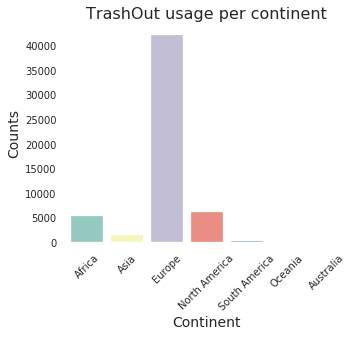

In [56]:
# Remove columns

drop = ['country', 'aa1', 'aa2', 'aa3', 'iso3c', 'region_id', 'gdp']

df_merged = df_merged_wbi.drop(drop, axis=1)

# Plot data counts per continent

import seaborn as sns

continent_count = df_merged['continent'].value_counts()

print(continent_count)


fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(data = df_merged,
               x= 'continent',
               palette = "Set3",
               orient = 'h').set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title('TrashOut usage per continent', fontsize= 16)
ax.set_ylabel('Counts', fontsize=14);
ax.set_xlabel('Continent', fontsize=14);



### Global correlations among trash kind### 

We start our correlation analysis looking at first only into the data in the TrashOut data set. The analysis can be done following the heatmap below, for the following TrashOut variables for illegal dumping:

['automotive', 'construction', 'dangerous', 'deadAnimals', 'domestic', 'electronic', 'glass', 'liquid', 'metal', 'organic', 'plastic', 'byCar', 'inCave', 'notForGeneralCleanup', 'underWater']


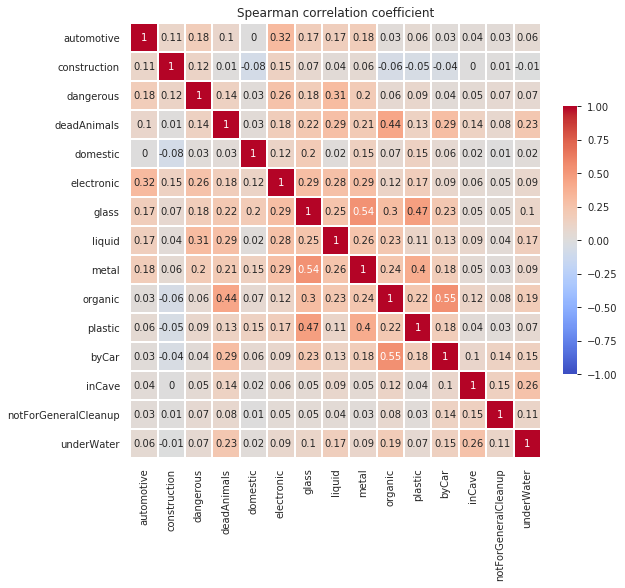

In [17]:
# Resource: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

# Global correlations among Trash types 

#add list of variables from merged
variables = list(df_merged.columns)
keep = ['automotive', 'construction', 'dangerous', 'deadAnimals', 'domestic', 'electronic', 'glass', 'liquid', 'metal', 'organic', 'plastic', 'byCar', 'inCave', 
        'notForGeneralCleanup', 'underWater']


drop_corr_trash = set(variables) - set(keep)

df_corr_trash = df_merged.drop(drop_corr_trash, axis=1)

# Correlation matrix
corr_num = df_corr_trash.corr(method = "spearman")


fig, ax = plt.subplots(figsize=(8,8))
#fig, ax = plt.subplots()

sns.heatmap(corr_num,
            annot = corr_num.round(2),
            #square=True,
            linewidth=1,# space between cells
            cmap="coolwarm", 
            vmin=-1, vmax=1,
            cbar_kws={'fraction' : 0.03}, # shrink color bar
            ax = ax);
#ax.set(ylim=(0, 95));

ax.set_title("Spearman correlation coefficient");

print(keep)

In the diagram, red colors indicate strong correlation, blue colors indicate strong anticorrelation and gray color indicate weak correlation/anticorrelation. 

Overall, no strong correlation among illegal trash types. Moderate correlation (above 0.4)) among:

* *byCar* and *organic*
* *deadAnimals* and *organic*
* *plastic* and *glass*
* *plastic* and *metal* 

### Global correlations among What a Waste indicators###
We can now try to find different correlations among the types of illegal trash and the reported waste indicators from What a Waste dataset in a similar diagram, now considering also the following variables: 

['composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent', 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent', 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent', 'population_population_number_of_people', 'total_msw_total_msw_generated_tons_year', 'special_waste_e_waste_tons_year']


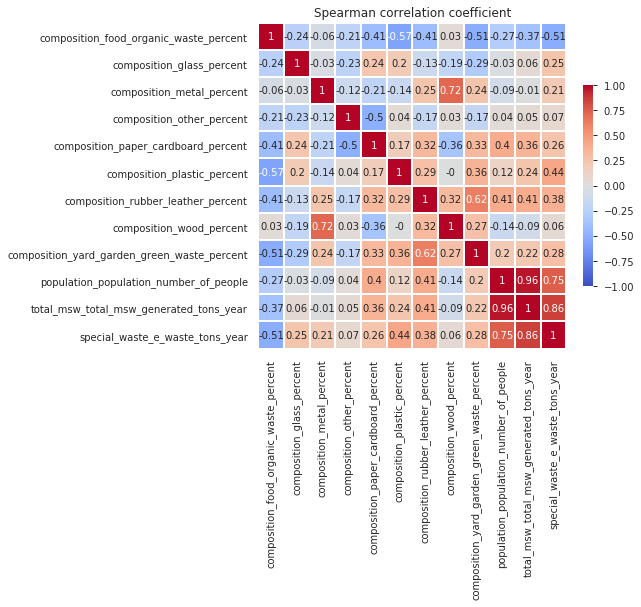

In [18]:
# Global correlations among Trash types and waste indicators 

#add list of variables from merged
variables = list(df_merged.columns)
#keep = ['automotive', 'construction', 'dangerous', 'deadAnimals', 'domestic', 'electronic', 'glass', 'liquid', 
#        'metal', 'organic', 'plastic', 'byCar', 'inCave', 'notForGeneralCleanup', 'underWater', 
# 'composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent',
# 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent',
# 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent',
# 'population_population_number_of_people', 'total_msw_total_msw_generated_tons_year', 'special_waste_e_waste_tons_year']

keep = ['composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent',
 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent',
 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent',
 'population_population_number_of_people', 'total_msw_total_msw_generated_tons_year', 'special_waste_e_waste_tons_year']

drop_corr_waste = set(variables) - set(keep)

df_corr_waste = df_merged.drop(drop_corr_waste, axis=1)

# Correlation matrix
corr_num = df_corr_waste.corr(method = "spearman")


fig, ax = plt.subplots(figsize=(6,6))
#fig, ax = plt.subplots()

sns.heatmap(corr_num,
            annot = corr_num.round(2),
            #square=True,
            linewidth=1,# space between cells
            cmap="coolwarm", 
            vmin=-1, vmax=1,
            cbar_kws={'fraction' : 0.03}, # shrink color bar
            ax = ax);
#ax.set(ylim=(0, 95));

ax.set_title("Spearman correlation coefficient");

print(keep)


Here again we do not find any strong correlation among the kind of trash (TrashOut dataset) and the waste indicators (What a Waste dataset), therefore, do now display in the diagram. However, the regular waste indicators present correlations among themselves. 

Looking at the waste indicators in the diagram above, we can notice both correlations and anti-correlations that can give insights on global waste composition that is reported:

* Food/organic_waste present moderate **anticorrelation** (between -0.41 and -0.57) to plastic, cardboard, yard/green waste, rubber/leather and special waste. Meaning that high amounts of organic waste are associated with less of the mentioned types of waste, 
* Metal and wood have a moderate/high correlation of 0.72, meaning that higher amounts of these types of trash are commonly found in association to each other,
* Yard/ green waste are also moderately correlated (0.62) to rubber/leather waste, 
* Plastic is moderately correlated (0.44) to special waste, and anticorrelated to food/organic waste (-0.41) as already mentioned above,
* Special waste is associated to population and strongly correlated to the total generated tons per year (0.86),
* Finally, we identify that **population** is strongly correlated to generated tons of waste per year (0.96) and  moderately/highly correlated special waste (0.75)

### Combined TrashOut, What a Waste and World Bank Indicators datasets###

In the following, we analyze the merged 3 datasets.

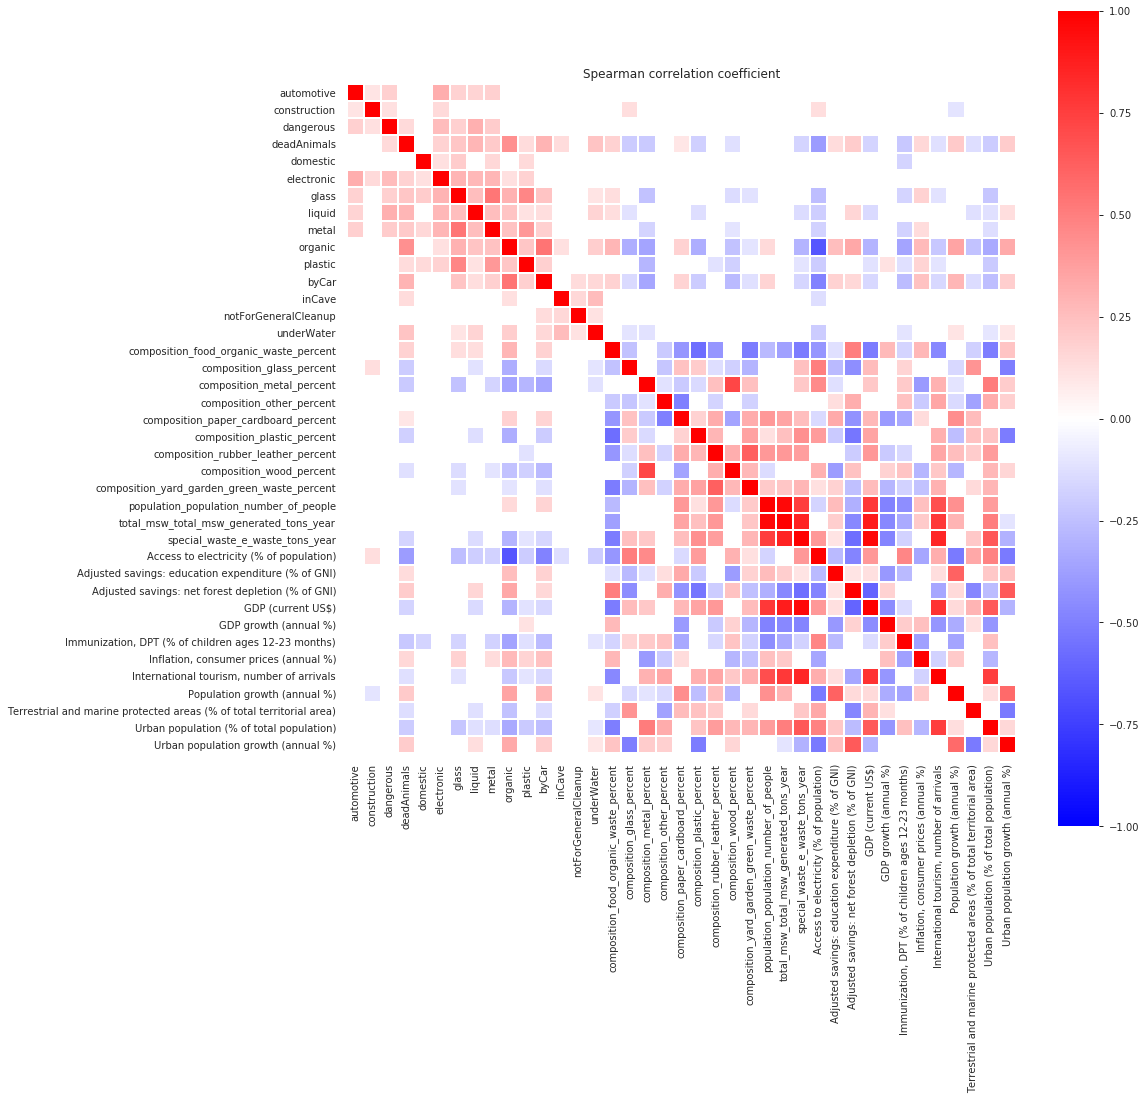

In [19]:
#TODO
# Global correlations among Trash types, waste and socio-economic indicators 

# Change data type of WBI variables (stored as objects)
wbi_vars = [ 'Access to electricity (% of population)', 'Adjusted savings: education expenditure (% of GNI)', 
 'Adjusted savings: net forest depletion (% of GNI)',
 'GDP (current US$)', 'GDP growth (annual %)', 'Immunization, DPT (% of children ages 12-23 months)',
 'Immunization, HepB3 (% of one-year-old children)', 'Immunization, measles (% of children ages 12-23 months)',
 'Inflation, consumer prices (annual %)', 'International tourism, number of arrivals',
 'Population growth (annual %)', 'Terrestrial and marine protected areas (% of total territorial area)',
 'Urban population (% of total population)', 'Urban population growth (annual %)']

df_merged[wbi_vars] = df_merged[wbi_vars].apply(pd.to_numeric)


variables = list(df_merged.columns)
keep = ['automotive', 'construction', 'dangerous', 'deadAnimals', 'domestic', 'electronic', 'glass', 'liquid', 
        'metal', 'organic', 'plastic', 'byCar', 'inCave', 'notForGeneralCleanup', 'underWater', 
        'composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent',
 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent',
 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent',
 'population_population_number_of_people', 'total_msw_total_msw_generated_tons_year', 
 'special_waste_e_waste_tons_year',
 'Access to electricity (% of population)', 'Adjusted savings: education expenditure (% of GNI)', 
 'Adjusted savings: net forest depletion (% of GNI)',
 'GDP (current US$)', 'GDP growth (annual %)', 'Immunization, DPT (% of children ages 12-23 months)',
# 'Immunization, HepB3 (% of one-year-old children)', 'Immunization, measles (% of children ages 12-23 months)',
 'Inflation, consumer prices (annual %)', 'International tourism, number of arrivals',
 'Population growth (annual %)', 'Terrestrial and marine protected areas (% of total territorial area)',
 'Urban population (% of total population)', 'Urban population growth (annual %)']

#print('Urban population (% of total population)' in variables)

drop_corr_wbi = set(variables) - set(keep)


df_corr_wbi = df_merged.drop(drop_corr_wbi, axis=1)
# Correlation matrix
corr_num = df_corr_wbi.corr(method = "spearman")



fig, ax = plt.subplots(figsize=(15,15))
#fig, ax = plt.subplots()

sns.heatmap(corr_num,
#            annot = corr_num.round(2),
            square=True,
            linewidth=1,# space between cells
            cmap="bwr", 
            vmin=-1, vmax=1,
            #cbar_kws={'fraction' : 0.03}, # shrink color bar
            ax = ax,
            mask = abs(corr_num) < 0.1);
#ax.set(ylim=(0, 95));

ax.set_title("Spearman correlation coefficient");
 


Here, red indicates stronger correlation and blue indicates stronger anticorrelation, whereas white and light colors indicate weak correlation/anticorrelation. Highlights about the relationship between the illegal dumpside data from *TrashOut* and the *What a Waste* and *World Bank* datasets is the following, visible in the bottom left  part of the heatmap above: 

* We identify TrashOut indicators for illegal dumping which do not present significant  correlation/anticorrelation (- 0.15 < corr < 0.15) to any indicator from the other data sets: `automotive`, `construction`, `dangerous`, `domestic`, `electronic`, `inCave`, `notForGeneralCleanup`. This can be associated to lack of data in the TrashOut data set for such indicators, as these are less common type of trash (verify).

* The indicator `glass` has only significant correlation with the socio-economic indicators from the World Bank data set.

* Vertical lines with light colors are associated to the indicators `deadAnimals`, `organic` and `byCar`, showing  moderate correlation (0.15 < corr < 0.4, -0.4 < corr < -0.15) to several global indicators from the What a Waste and World Bank datasets. 

* The remaining indicators from the TrashOut data set (`metal`, `glass`, `liquid`, `plastic`, `underWater`)  present weak correlations to the indicators in the analysis.


When we now look into the horizontal lines in the same bottom left part of the diagram, we identify the relevant correlations among the World Bank socio-economic indicators to the TrashOut data. The following indicators correlate/anticorrelate to several TrashOut indicators:

* `Access to electricity` anticorrelates with most TrashOut indicators, showing that low access to electricity can be associated to higher illegal dumping rates for most kinds of trash (specially to `organic`),  

* `Immunization, DPT`, also anticorrelates to most kinds of illegal dumpings, indicating that lower levels of development and sanitation can be related to illegal dumpings,  

* `Inflation`, has a higher correlation to most common illegal kinds of trash, showing that economic factors (high inflation) can play a relevant role in the illegal disposal of trash, 

* `Urban population` and `Urban population growth` present interesting opposite correlation behavior regarding the illegal trash disposal. More illegal dumping is associated to lower `Urban population` and higher `Urban population growth`, which could be related to developing countries in which the rural population is large and not always have the proper infrastructure for waste disposal. In the same way, developing coutries are the ones that have the largest percentage increase in urban population.

Looking into the correlations among TrashOut and What a Waste data (central left), we identify:

* Illegal trash correlates to `population count` but anticorrelates to `special waste`, indicating that higher populations produce more trash and dispose a part of it illegaly. However, looking at the right part of the heat map, associated to reported waste from What a Waste, it is possible to see that countries with a large amount of special waste production have anticorrelation with illegal dumps. This is a remarkable observation, because countries with high populations also produce more special waste, as we are going to discuss next.  


## Global reported trash production ##

Now, we focus our analysis on the correlations among the What a Waste indicators and the socio-economic indicators from World Bank. The data reported in the What a Waste data set is associated to legal dumping of different kinds of trash. This analysis is a complementary part of the study, as an attempt to better understand the illegal dumping problem from the TrashOut data set. 

Let's start selecting only the data present in these two data sets and calculating their correlations, as already shown in the diagram from the previous session.


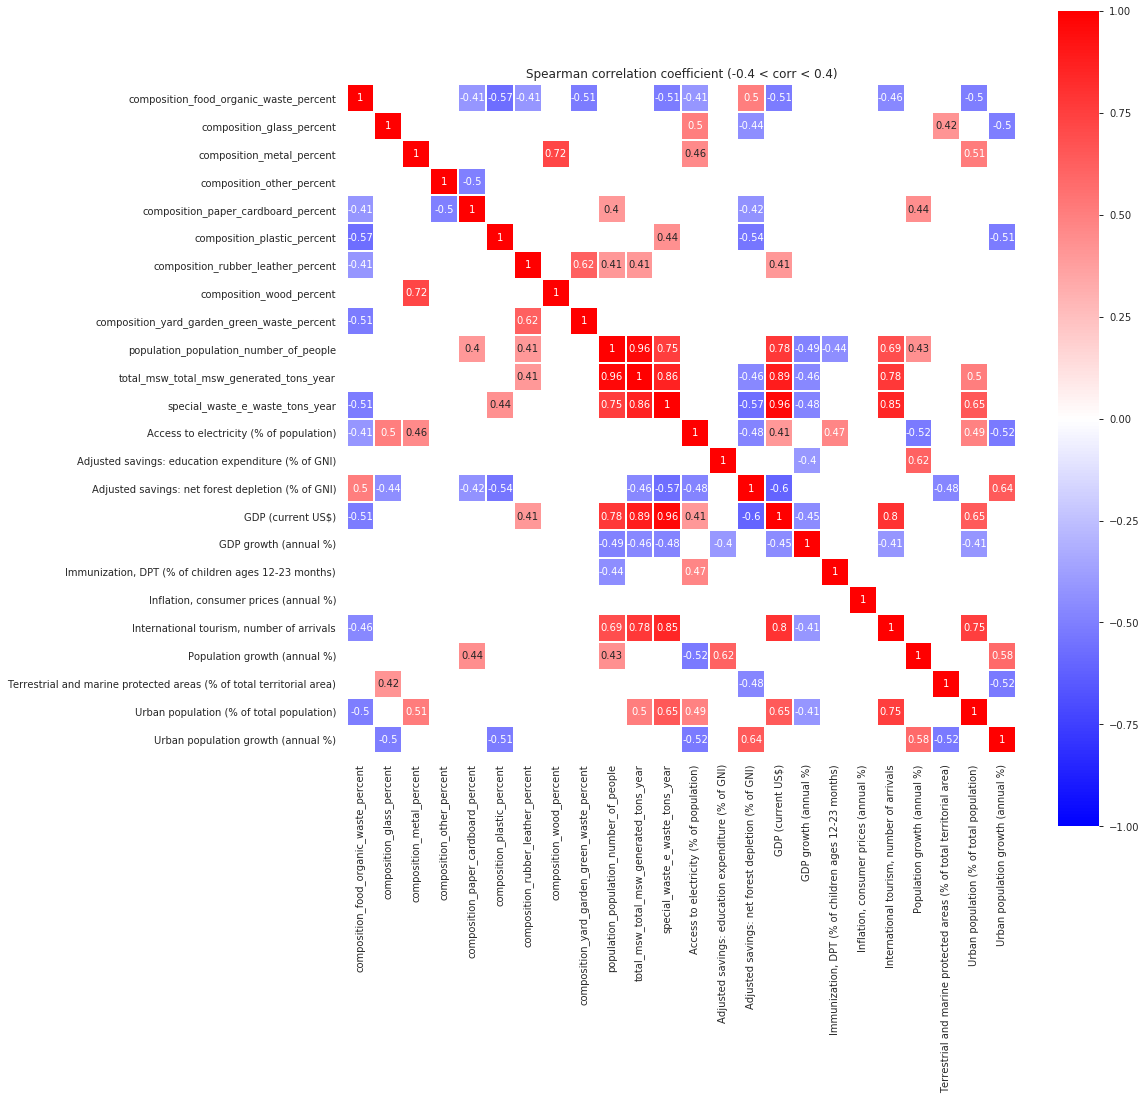

In [20]:
variables = list(df_merged.columns)
keep = ['composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent',
 'composition_other_percent', 'composition_paper_cardboard_percent', 'composition_plastic_percent',
 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent',
 'population_population_number_of_people', 'total_msw_total_msw_generated_tons_year', 
 'special_waste_e_waste_tons_year',
 'Access to electricity (% of population)', 'Adjusted savings: education expenditure (% of GNI)', 
 'Adjusted savings: net forest depletion (% of GNI)',
 'GDP (current US$)', 'GDP growth (annual %)', 'Immunization, DPT (% of children ages 12-23 months)',
 'Inflation, consumer prices (annual %)', 'International tourism, number of arrivals',
 'Population growth (annual %)', 'Terrestrial and marine protected areas (% of total territorial area)',
 'Urban population (% of total population)', 'Urban population growth (annual %)']

#print('Urban population (% of total population)' in variables)

drop_corr_waw_wbi = set(variables) - set(keep)


df_corr_waw_wbi = df_merged.drop(drop_corr_waw_wbi, axis=1)
# Correlation matrix
corr_num = df_corr_waw_wbi.corr(method = "spearman")

fig, ax = plt.subplots(figsize=(15,15))
#fig, ax = plt.subplots()

sns.heatmap(corr_num,
            annot = corr_num.round(2),
            square=True,
            linewidth=1,# space between cells
            cmap="bwr", 
            vmin=-1, vmax=1,
            #cbar_kws={'fraction' : 0.03}, # shrink color bar
            ax = ax,
            mask = abs(corr_num) < 0.4);
#ax.set(ylim=(0, 95));

ax.set_title("Spearman correlation coefficient (-0.4 < corr < 0.4)");

Here again we are using a cutoff in the correlations, in order to only capture moderate and high correlations (>0.4) and anticorrelations (< -0.4). 

* , `Access to electricity` associated to `organic waste`, `composition of glass`, `composition of metal`
* `Urban population` associated to `organic waste`, `metal waste`

 **Sustainability indicators:** 
* `Adjusted savings: net forest depletion` associated to `organic waste`, `composition of glass`, `composition of paper/cardboard` , `composition of plastic`, 
* `Terrestrial and marine protected areas` associated to `composition of glass percentage`

* `special waste` is highly correlated to `population` and `municipal solid waste production (msw)`, and anticorrelated to `organic waste`. 


## Clustering Countries by Reported Waste ##

The next step in our analysis is to investigate how the different World Bank indicators can be clustered in relation to the different kinds of waste produced worldwide. For doing so, we apply a *Clustering* technique from Machine Learning, called *K-means Clustering* as a starting point. The steps for this analysis are the following:

* Select only countries from the merged data set,
* Deal with missing values (using KNN imputer - which takes the average value of the neighboring clustered variables for a missing value),
* Apply the clustering method.


In [21]:
# Selecting only contries once and storing countries indexes in a list

countries_id = df_merged['country_name'].drop_duplicates()

df_waw_wbi_nodupl = df_corr_waw_wbi.drop_duplicates()

# KNN imputing applied to the whole data frame df_corr_waw_wbi

#pprint(df_corr_waw_wbi.columns)

from numpy import isnan
from sklearn.impute import KNNImputer

# print total missing
#print(df_waw_wbi_nodupl.isnull().sum())

# define imputer
imputer = KNNImputer()

# fit on the dataset
imputer.fit(df_waw_wbi_nodupl)

# transform the dataset and store is as a pandas dataframe (imputer generates np array)
df_waw_wbi = pd.DataFrame(data=imputer.transform(df_waw_wbi_nodupl), 
                          columns = df_waw_wbi_nodupl.columns, index = df_waw_wbi_nodupl.index)


# print total missing
#print(df_waw_wbi.isnull().sum())


Once identifying the missing values and substituting them by the output of KNN imputer, we now have a dataset `df_waw_wbi` containing only the country based data for the two data sets of interests (What a Waste and World Bank). We can now move on to the clustering analysis. 

We start with identify the optimal number of neighbors `k` for the clustering: 

In [22]:
# Clustering Kmeans
# Resource: https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c
# Resource: https://medium.com/predict/three-popular-clustering-methods-and-when-to-use-each-4227c80ba2b6

from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sum_of_squared_distances = []
K = range(2,10)
for k in K:
    QtlTransf = QuantileTransformer(n_quantiles = len(df_waw_wbi)) # for help with outliers
    X = QtlTransf.fit_transform(df_waw_wbi)

    pca_95 = PCA(0.95) # reduce dimensionality
    X = pca_95.fit_transform(X)

    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df_waw_wbi)
    sum_of_squared_distances.append(k_means.inertia_)

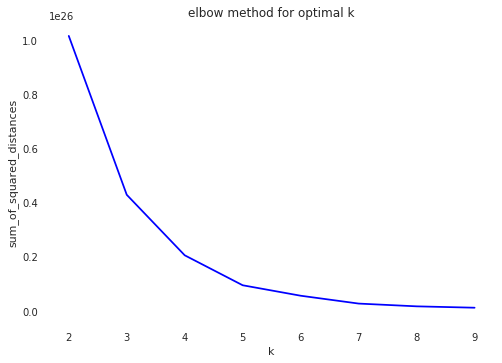

In [23]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()


We identify that the optimal number is around 4. We continue with applying *Principle Component Analysis* to identify the variables relevant for the clustering. 


In [24]:
QtlTransf = QuantileTransformer(n_quantiles = len(df_waw_wbi))
X = QtlTransf.fit_transform(df_waw_wbi)

pca_95 = PCA(0.95)
X = pca_95.fit_transform(X)

model_knn = KMeans(n_clusters=4, max_iter=10, n_init=30, random_state=42)
model_knn.fit(X)

X.shape

(156, 17)

We find that reducing the number of variables from 24 to 17 is sufficient to explain 95% of the data. 


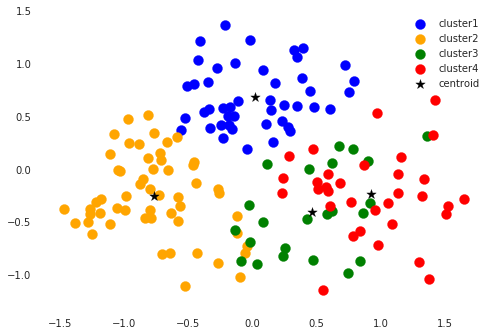

In [25]:
pred = model_knn.predict(X)

plt.scatter(X[pred == 0, 0], X[pred == 0, 1], s=100, color='blue', label='cluster1')
plt.scatter(X[pred == 1, 0], X[pred == 1, 1], s=100, color='orange', label='cluster2')
plt.scatter(X[pred == 2, 0], X[pred == 2, 1], s=100, color='green', label='cluster3')
plt.scatter(X[pred == 3, 0], X[pred == 3, 1], s=100, color='red', label='cluster4')

plt.scatter(model_knn.cluster_centers_[:, 0], model_knn.cluster_centers_[:, 1], s=100, color='black',
            label='centroid', marker='*')
plt.legend()

We can also have a look into the clusters in a 3D plot:

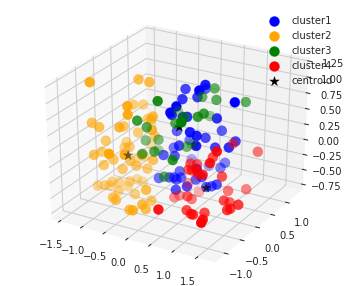

In [55]:
# Resource: https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb

#tsne_3d_df = prepare_tsne(3, df_waw_wbi, kmeans.labels_)
#plot_animation(tsne_3d_df, 'kmeans', 'kmeans')

#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[pred == 0, 0], X[pred == 0, 1], X[pred == 0, 2],color='blue', s=100, label='cluster1')
ax.scatter(X[pred == 1, 0], X[pred == 1, 1],X[pred == 1, 2], color='orange', s=100, label='cluster2')
ax.scatter(X[pred == 2, 0], X[pred == 2, 1], X[pred == 2, 2],color='green', s=100, label='cluster3')
ax.scatter(X[pred == 3, 0], X[pred == 3, 1], X[pred == 3, 2],color='red', s=100, label='cluster4')

ax.scatter(model_knn.cluster_centers_[:, 0], model_knn.cluster_centers_[:, 1], model_knn.cluster_centers_[:, 2], 
           s=100, color='black',
            label='centroid', marker='*')
plt.legend()



The images show that there are differences among clusters, but also similarities. In order to understand their different behaviors, let's see how our indicators are clustered according to these categories. 

We first have a look in the counts of countries in each of these clusters:

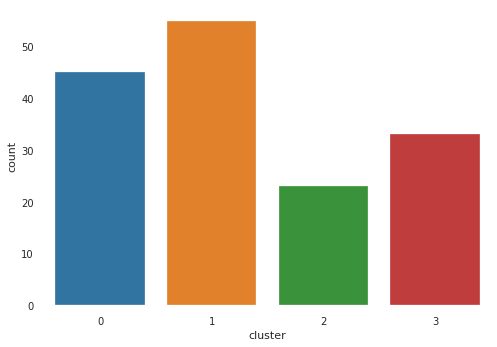

In [27]:
# Adding the prediction into the dataframe
df_waw_wbi['cluster'] = pred

# Visualizing group
sns.countplot(df_waw_wbi['cluster'])

In the image above, we can see 4 clusters in the colors *blue, orange, green and red* which we will use to denote each cluster in our following analysis: 

* Cluster Blue: about 45 countries,

* Cluster Orange: about 55 countries,

* Cluster Green: about 25 countries,

* Cluster Red: about 35 countries, 

which accounts for all countries considered in our analysis. 

Our next step is have a look into how these clusters of countries are related to the most relevant indicators considered in our analysis. 

We start with the socio-economic indicators:

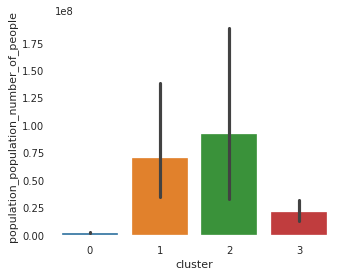

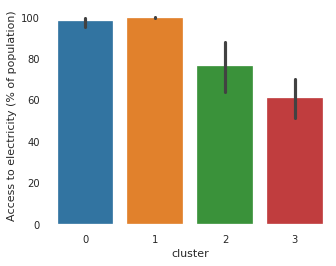

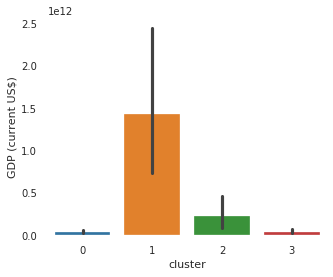

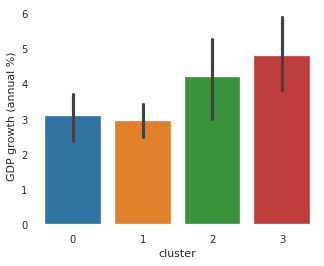

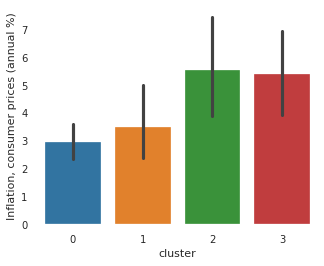

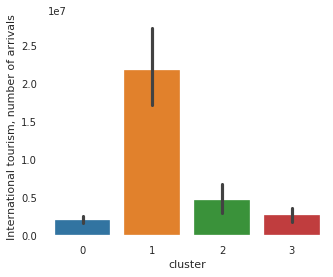

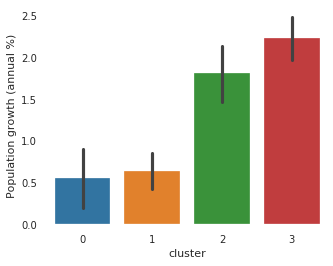

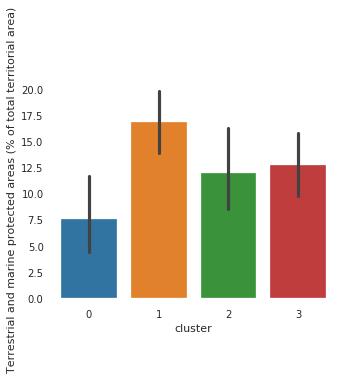

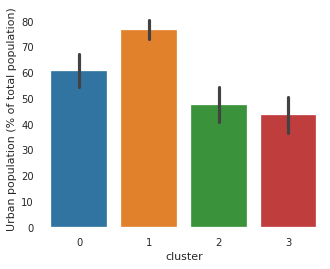

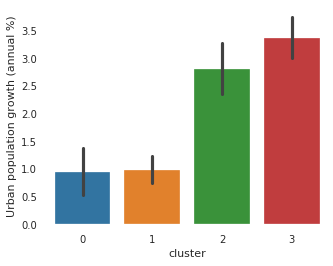

In [52]:
# Visualizing features relevant for clustering (remove features that do not change so much)

remove = ['Adjusted savings: education expenditure (% of GNI)', 
          'Adjusted savings: net forest depletion (% of GNI)',
          'Immunization, DPT (% of children ages 12-23 months)']

wbi = ['population_population_number_of_people', 'Access to electricity (% of population)', 
 'GDP (current US$)', 'GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'International tourism, number of arrivals',
 'Population growth (annual %)', 'Terrestrial and marine protected areas (% of total territorial area)',
 'Urban population (% of total population)', 'Urban population growth (annual %)']
    
    

for feature in wbi:
    plt.figure(figsize=(5,4))
    sns.barplot(x='cluster', y=feature, data=df_waw_wbi)

plt.show()

We can have a closer look into the distribution of some development factors across the clusters:

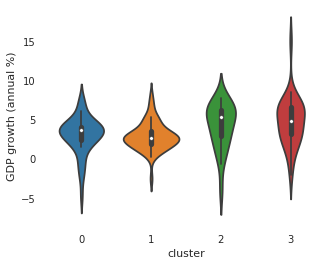

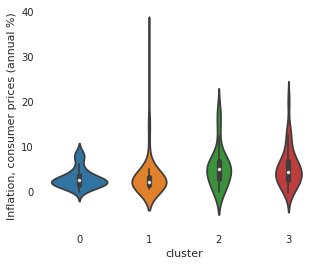

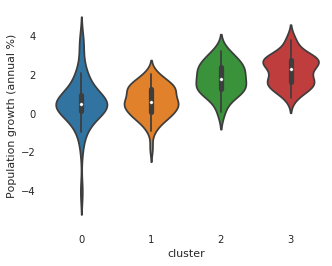

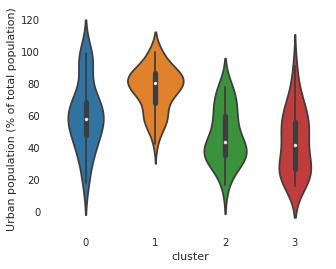

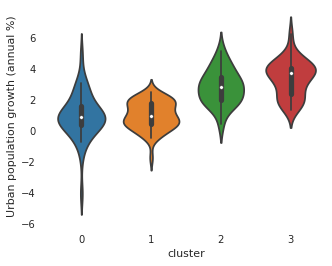

In [51]:
# Visualizing features relevant for clustering (remove features that do not change so much)

remove = ['Adjusted savings: education expenditure (% of GNI)', 
          'Adjusted savings: net forest depletion (% of GNI)',
          'Immunization, DPT (% of children ages 12-23 months)']

wbi = ['GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'Population growth (annual %)', 
       'Urban population (% of total population)', 'Urban population growth (annual %)']
    
    

for feature in wbi:
    plt.figure(figsize=(5,4))
    sns.violinplot(x='cluster', y=feature, data=df_waw_wbi)

plt.show()

From these indicators, we can identify socio-economic patterns associated to the countries:


* Blue cluster: countries with small population and population growth, but high urban populations and access to electricity. These countries have also low urban population growth and GDP. From such patterns, we can identify these as **developed countries with small population**. 

* Orange cluster: countries with the highest GDP, and also high access to electricity, urban  population, tourism. Low inflation and urban population growth. These are patters usually associated to **developed countries with high  population **. 

* Green cluster: countries with the highest population and inflation; moderate access to electricity and GDP
big developing countries, and growing urban and total population. From these characteristics, we can associate these countries to **developing countries with high population**. 

* Red cluster: countries with a small population and GDP; lowest electricity access, but highest GDP and population (including urban) growth. This cluster is associated to **developing countries with low population and income**

Once we identified some patterns in our clusters of countries, we can now see how they represent the reported waste in the world, for the indicators in the What a Waste data set.


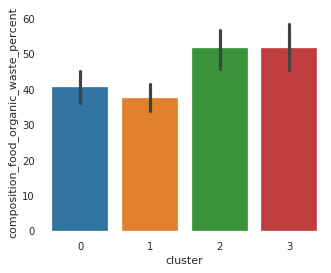

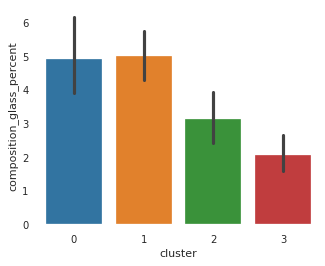

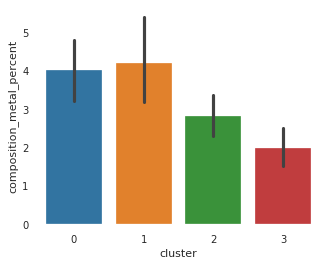

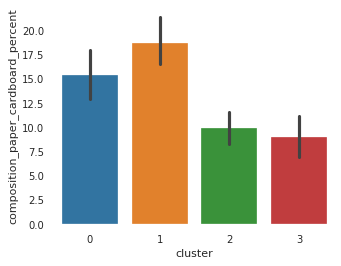

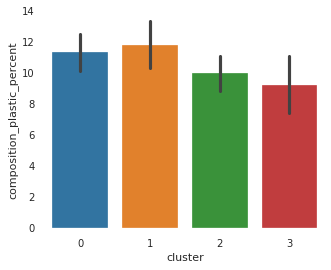

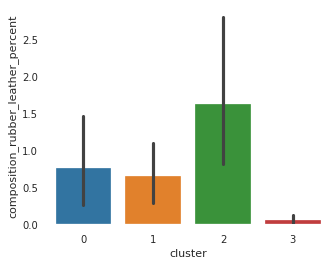

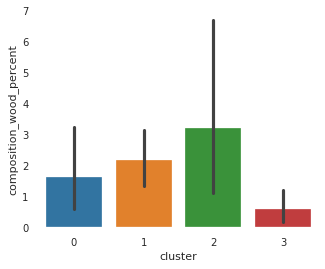

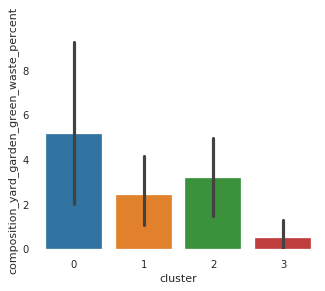

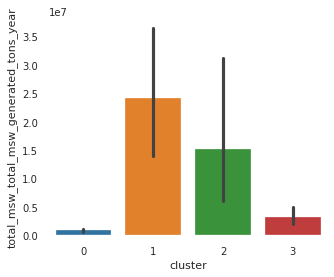

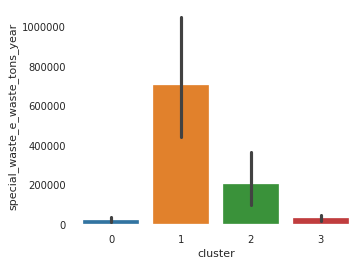

In [50]:
waw = ['composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent',
 'composition_paper_cardboard_percent', 'composition_plastic_percent',
 'composition_rubber_leather_percent', 'composition_wood_percent', 'composition_yard_garden_green_waste_percent',
 'total_msw_total_msw_generated_tons_year', 
 'special_waste_e_waste_tons_year']
    

for feature in waw:
    plt.figure(figsize=(5,4))
    sns.barplot(x='cluster', y=feature, data=df_waw_wbi)
    
plt.show()

We can also have a look into the distribution of the most common types of waste in the clusters:

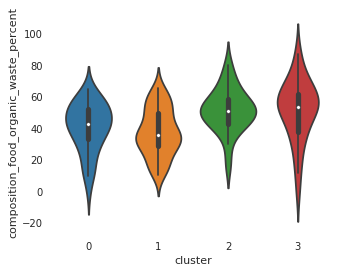

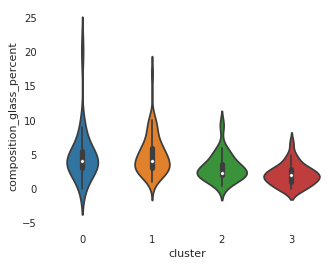

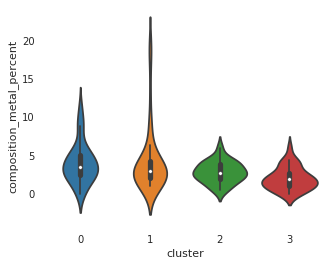

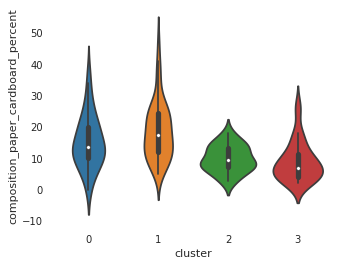

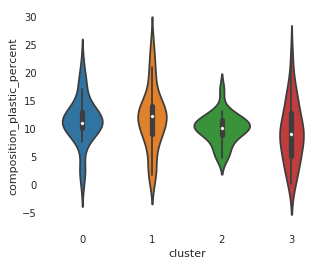

In [49]:
waw = ['composition_food_organic_waste_percent', 'composition_glass_percent', 'composition_metal_percent',
 'composition_paper_cardboard_percent', 'composition_plastic_percent']
    

for feature in waw:
    plt.figure(figsize=(5,4))
    sns.violinplot(x='cluster', y=feature, data=df_waw_wbi)


plt.show()


* Our first highlight is that **plastic waste production is high in all clusters**

* **Blue cluster (small developed countries):** presents a high production of glass, metal and paper/cardboard waste, and the highest production of yard/green waste.  

* **Orange cluster (high population developed countries)**: also produces high amounts of glass and paper/cardboard and are responsible for the highest production of special waste and total municipal solid waste: These countries are also associated with the lowest production of organic waste.  

* **Green cluster (high population developing countries):** generate high amounts of organic, rubber/leather and wood waste, and low amounts of glass. This can be associated to the high population being less concentrated in cities and also to the level of industrialization of such countries, which may be the ones that most produce factory materials such as leather and rubber.

* **Red cluster (small developing countries/low income):** most of the waste produced in these countries is from food and organic sources. These are the countries that also produce the lowest amounts of glass, metal and rubber/leather waste. Such scenarios can be associated to the low populations and also a possible use of waste in a sustainable way, as these countries also present low production of green/yard and wood waste. 

In summary, population is a crucial factor for the production of waste. In particular, if the population is concentrated in cities (Orange cluster) the special waste and municipal solid waste is higher. If the population is high and more concentrated in rural areas (Green cluster), then the highest production of trash is associated to organic trash. If the population and income is low, the trash is mostly translated into organic waste. 


In [32]:
# Adding the countries back to the data frame (from keeping ID)
df_waw_wbi['country_name'] = countries_id

# Select the clusters and displaying country names

blue = list(df_waw_wbi[df_waw_wbi['cluster']== 0]['country_name'])
orange = list(df_waw_wbi[df_waw_wbi['cluster']== 1]['country_name'])
green = list(df_waw_wbi[df_waw_wbi['cluster']== 2]['country_name'])
red = list(df_waw_wbi[df_waw_wbi['cluster']== 3]['country_name'])

#print('Blue cluster')
#pprint(list(blue))


#print('Orange cluster')
#pprint(list(orange))

#print('Green cluster')
#pprint(list(green))


#print('Red cluster')
#pprint(list(red))

#df_waw_wbi.head()
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import pandas as pd
from descartes import PolygonPatch

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

# Checking mathching names of countries
world.loc[world.name == 'Congo', 'name'] = 'Democratic Republic of the Congo'
world.loc[world.name == 'United States of America', 'name'] = 'United States'
world.loc[world.name == 'Gambia', 'name'] = 'The Gambia'
world.loc[world.name == 'Myanmar', 'name'] = 'Myanmar (Burma)'
world.loc[world.name == 'Macedonia', 'name'] = 'Macedonia (FYROM)'
world.loc[world.name == 'Dominican Rep.', 'name'] = 'Dominican Republic'
world.loc[world.name == 'Bosnia and Herz.', 'name'] = 'Bosnia and Herzegovina'

#Missing countries in world: São Tomé and Príncipe, Singapore, Samoa,  'Saint Lucia', 'Saint Vincent and the Grenadines''Maldives', 'Malta', 'Mauritius','Faroe Islands', 'Grenada', 'Guam', 'Hong Kong',
# Selecting countries for both data sets for comparison
t_name = set( df_waw_wbi['country_name'])
w_name = set(world['name'])


#countries difference from data sets
countries_diff_tw = t_name - w_name
countries_diff_wt = w_name - t_name

# Countries in TrashOut data but not in World
countries_diff_tw.remove(np.nan)
t_name.remove(np.nan)

#print('TrashOut countries missing in World:', sorted(countries_diff_tw))
#print()
#pprint(sorted(t_name))

#world.head()

In [33]:
# Create function that reads df country and cluster then adds the corresponding cluster in the world df 

def countries_clusters():
 
    world_countries = world['name']
    clusters = []
    
    for name in world_countries:

        if name in blue:
            cluster= 'Blue'
        elif name in orange:
            cluster='Orange'
        elif name in green:
            cluster='Green'
        elif name in red:
            cluster='Red'
        else:
            cluster='Other'
        clusters.append(cluster)
    world['cluster']= clusters

countries_clusters() 


#world.head(50)


Geographically, one can associate these clusters with the following countries in the world:

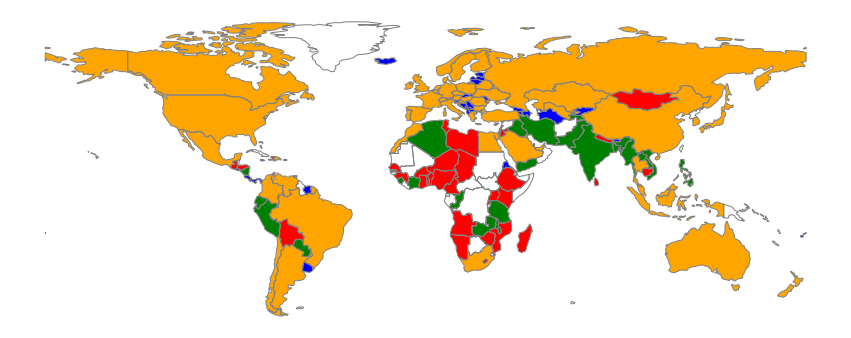

In [34]:
# Plot the whole world
#ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )
# cmap='Pastel1'

# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,15))

world.boundary.plot(ax = ax, linewidth = 1 , color = 'grey')

world[world['cluster']=='Other'].plot(ax=ax, color='white')
world[world['cluster']=='Blue'].plot(ax=ax, color='blue')
world[world['cluster']=='Orange'].plot(ax=ax, color='orange')
world[world['cluster']=='Green'].plot(ax=ax, color='green')
world[world['cluster']=='Red'].plot(ax=ax, color='red')

#            cluster= 'Cluster Blue: low pop. developed'
#            cluster='Cluster Orange: high pop. developed'
#            cluster='Cluster Green: high pop developing'
#            cluster='Cluster Red: low pop. developing'



ax.set_xticks([], [])
ax.set_yticks([], [])
ax.axis('off')

#ax2.axis('scaled')
plt.show()



We can now finally see how these different clusters are related to the illegal dumping in the TrashOut data.

In [35]:
# Merge clusters information in the general df with the 3 data sets

df_merged_wbi_c = df_merged_wbi.merge(df_waw_wbi.rename(columns={'country_name': 'country'}), on='country')

#df_merged_wbi.head(150)
#df_waw_wbi.columns
#pprint(list(df_merged_wbi.columns))


In [36]:

# Select dataframes for each cluster from merged df
trash= ['automotive', 'construction', 'deadAnimals', 'domestic',  'electronic', 'glass', 
        'liquid', 'metal',  'organic', 'plastic', 'byCar']

blue_l =len(df_merged_wbi_c[df_merged_wbi_c['cluster']== 0])
orange_l =len(df_merged_wbi_c[df_merged_wbi_c['cluster']== 1])
green_l =len(df_merged_wbi_c[df_merged_wbi_c['cluster']== 2])
red_l =len(df_merged_wbi_c[df_merged_wbi_c['cluster']== 3])


blue_c = list(df_merged_wbi_c[df_merged_wbi_c['cluster']== 0][trash].sum())
orange_c = list(df_merged_wbi_c[df_merged_wbi_c['cluster']== 1][trash].sum())
green_c = list(df_merged_wbi_c[df_merged_wbi_c['cluster']== 2][trash].sum())
red_c = list(df_merged_wbi_c[df_merged_wbi_c['cluster']== 3][trash].sum())


#print(df_merged_wbi.groupby(['cluster']).count())


#print(len(df_merged_wbi['longitude'])) 
#print(len(set(df_merged_wbi['longitude'])))


First, let's see how the total amount of reported illegal dumpsites from TrashOut users is represented among the clusters: 

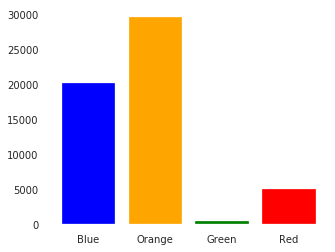

In [48]:
#df = pd.DataFrame({'Blue': blue_l, 'Orange': orange_l, 'Green': green_l, 'Red': red_l})

#ax = df.plot.bar(index=['Blue', 'Orange', 'Green', 'Red'])

#ax.set_xticklabels(trash, rotation=45);

plt.figure(figsize=(5,4))
plt.bar(['Blue', 'Orange', 'Green', 'Red'], [blue_l, orange_l, green_l, red_l], color = ['blue', 'orange', 'green', 'red'])
    
plt.show()

We can see that most of the reported TrashOut illegal dumpsites come from users in low and high population developed countries (Blue and Orange clusters). Most of the high population developing countries (Green clusters) are not represented in the TrashOut data. These correspond to most countries in South America and Asia, as seen before in this analysis.  

Nethertheless, we can still have a look into how the type of trash reported by TrashOut users is represented accross the clusters:

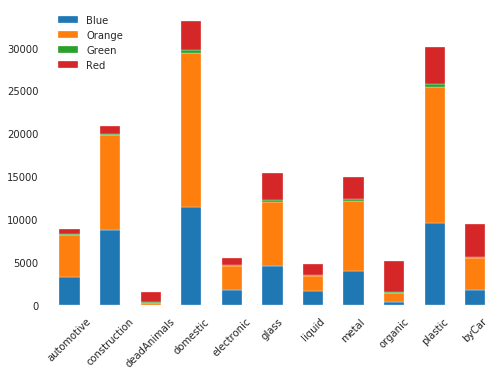

In [38]:
# Plot number of reports by kind of trash and cluster

#fig, ax = plt.subplots()

#ax.bar(trash, blue_c, color='blue')
#ax.bar(trash, orange_c, color='orange', bottom=blue_c)
#ax.bar(trash, green_c, color='green', bottom=blue_c+orange_c)
#ax.bar(trash, red_c, color='red', bottom=blue_c+orange_c+green_c)

df = pd.DataFrame({'Blue': blue_c, 'Orange': orange_c, 'Green': green_c, 'Red': red_c})

ax = df.plot.bar(stacked=True)

ax.set_xticklabels(trash, rotation=45);
#plt.legend(loc='center left',bbox_to_anchor=(1.01,0.5))
#plt.tight_layout()    


From the illustration above we can extract the following insights regarding reported illegal trash from TrashOut users:

* Most of illegal trash reported in low and high population developed countries (Blue and Orange cluster) is from `domestic`, `plastic` and  `construction` types,
* Most of illegal trash reported in low population developing countries (Red cluster) is from `domestic`, `plastic` and  `by Car` types,
* Not enough data is available in the TrashOut data set to represent the illegal dumping reports in high population developing countries (Green cluster).


### Summary ###

We carried out a broad analysis of the trash produced both legal and illegaly in the world. For doing so, we considered data from 3 datas sets, which illustrate global waste reports considering also socio-economic factors associated with infrastructure, development and economy of countries. 

Our main findings show that plastic is a global problem that must urgently be addressed by all authorities. 
Also, we identified that types of trash produced depend severely on the socio-economic status of countries. This is important to direct teh focus of future awareness campaings in different locations around the world. 

Regarding specifically the data from TrashOut, we identify that countries in South America and Asia are still not using the application. These are countries that account for the majority of organic and rubber/leather waste production in the world and having more TrashOut users in this locations may help to better understand how illegal dumping takes place in these locations. 